# Experiment: BAB Model Analysis from Saved Runs

Load saved checkpoints from `run_bab_models.py`, recompute predictions on all datasets, summarize train/test statistics, and reproduce comparison diagnostics.


In [13]:
# Setup
# If needed on Colab:
# !pip install torchdiffeq git+https://github.com/helonayala/bab_datasets.git

from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from hybrid_signal_learning import (
    load_protocol2_datasets,
    load_model_checkpoint,
    evaluate_model_on_dataset,
    plot_predictions,
    plot_zoom_position,
    plot_residuals,
    plot_raincloud_models,
    plot_y_vs_yhat,
    plot_acf,
    plot_spectra,
    model_display_name,
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1) Load run artifacts

Point `RUN_DIR` to one run folder generated by `scripts/run_bab_models.py`.


In [14]:
# Set this to your run folder
# RUN_DIR = Path("results/bab_runs") / "run_YYYYMMDD_HHMMSS"
RUN_DIR = Path("results/bab_runs") / "quick_local_with_swept"

config = json.loads((RUN_DIR / "metadata" / "config.json").read_text())
registry_json = json.loads((RUN_DIR / "metadata" / "model_registry.json").read_text())
best_ids = json.loads((RUN_DIR / "metadata" / "best_model_ids_test_r2_pos.json").read_text())

metrics_long = pd.read_csv(RUN_DIR / "tables" / "metrics_long.csv")
metrics_agg = pd.read_csv(RUN_DIR / "tables" / "metrics_aggregate.csv")
history_df = pd.read_csv(RUN_DIR / "tables" / "training_history.csv")

registry_df = pd.DataFrame(registry_json["models"])

print("RUN_DIR:", RUN_DIR)
print("Saved model checkpoints:", len(registry_df))
print("Best models (test r2_pos):")
print(best_ids)

display(metrics_long.head())


RUN_DIR: results/bab_runs/quick_local_with_swept
Saved model checkpoints: 5
Best models (test r2_pos):
{'linear': 'linear__physics__run00', 'stribeck': 'stribeck__physics__run00', 'blackbox': 'blackbox__base__run00', 'hybrid_joint': 'hybrid_joint__base__run00', 'hybrid_frozen': 'hybrid_frozen__base__run00'}


,model_id,model_key,nn_variant,run_idx,seed,dataset,split,rmse_pos,rmse_vel,r2_pos,r2_vel,fit_pos,fit_vel
0,linear__physics__run00,linear,physics,0,1234,multisine_05,train,1.173222,8.125253,0.199194,0.369487,10.512234,20.595183
1,linear__physics__run00,linear,physics,0,1234,multisine_05,test,1.302274,8.813667,0.169689,0.373502,8.878614,20.848364
2,linear__physics__run00,linear,physics,0,1234,multisine_06,train,1.251612,9.050778,0.116258,0.359883,5.992460,19.992677
3,linear__physics__run00,linear,physics,0,1234,multisine_06,test,1.168590,7.843051,0.317793,0.395732,17.404207,22.265308
4,linear__physics__run00,linear,physics,0,1234,random_steps_01,train,2.140737,21.201878,0.314217,0.266076,17.187960,14.330609


## 2) Statistical summary across all runs/variants

These tables summarize distribution of performance across all trained instances.


In [15]:
# Mean ± std over all runs/variants for each model_key, dataset, split
summary = (
    metrics_long
    .groupby(["model_key", "dataset", "split"], as_index=False)
    .agg(
        r2_pos_mean=("r2_pos", "mean"),
        r2_pos_std=("r2_pos", "std"),
        rmse_pos_mean=("rmse_pos", "mean"),
        rmse_pos_std=("rmse_pos", "std"),
        n=("model_id", "count"),
    )
)

display(summary.head(20))

# Optional: pivot view (R2 mean)
r2_mean_pivot = summary.pivot_table(index="model_key", columns=["dataset", "split"], values="r2_pos_mean")
rmse_mean_pivot = summary.pivot_table(index="model_key", columns=["dataset", "split"], values="rmse_pos_mean")

print("R2 mean table (position)")
display(r2_mean_pivot)
print("RMSE mean table (position)")
display(rmse_mean_pivot)


,model_key,dataset,split,r2_pos_mean,r2_pos_std,rmse_pos_mean,rmse_pos_std,n
0,blackbox,multisine_05,test,0.254475,NaN,1.233994,NaN,1
1,blackbox,multisine_05,train,0.224367,NaN,1.154635,NaN,1
2,blackbox,multisine_06,test,0.219955,NaN,1.249579,NaN,1
3,blackbox,multisine_06,train,-0.035337,NaN,1.354715,NaN,1
4,blackbox,random_steps_01,test,0.653976,NaN,1.460963,NaN,1
5,blackbox,random_steps_01,train,0.548528,NaN,1.736942,NaN,1
6,blackbox,random_steps_02,test,0.596003,NaN,1.561275,NaN,1
7,blackbox,random_steps_02,train,0.739584,NaN,1.281171,NaN,1
8,blackbox,random_steps_03,test,0.522004,NaN,1.503501,NaN,1
9,blackbox,random_steps_03,train,0.859177,NaN,0.984909,NaN,1


R2 mean table (position)


dataset       multisine_05           multisine_06           random_steps_01           random_steps_02           random_steps_03           random_steps_04           swept_sine
split                 test     train         test     train            test     train            test     train            test     train            test     train       test
model_key                                                                                                                                                                     
blackbox          0.254475  0.224367     0.219955 -0.035337        0.653976  0.548528        0.596003  0.739584        0.522004  0.859177        0.647045  0.818877   0.568793
hybrid_frozen     0.076133  0.246887    -0.285784  0.233031        0.822106  0.739732        0.554787  0.698243        0.413614  0.768596        0.854662  0.601767   0.354024
hybrid_joint     -0.711423 -0.223878    -1.128816 -0.602302        0.706447  0.743309        0.471135  0.620013        0.299266  0.823093        0.596727  0.767401  -0.594640
linear            0.169689  0.199194     0.317793  0.116258        0.267457  0.314217        0.307180  0.379985        0.259468  0.324016        0.020370  0.062887   0.399323
stribeck          0.276852  0.303822     0.397472  0.226684        0.294618  0.330598        0.358975  0.417950        0.305778  0.359253        0.086582  0.079377   0.452192

RMSE mean table (position)


dataset       multisine_05           multisine_06           random_steps_01           random_steps_02           random_steps_03           random_steps_04           swept_sine
split                 test     train         test     train            test     train            test     train            test     train            test     train       test
model_key                                                                                                                                                                     
blackbox          1.233994  1.154635     1.249579  1.354715        1.460963  1.736942        1.561275  1.281171        1.503501  0.984909        1.343698  1.071421   2.067577
hybrid_frozen     1.373683  1.137750     1.604309  1.165993        1.047533  1.318804        1.638983  1.379119        1.665266  1.262540        0.862247  1.588700   2.530621
hybrid_joint      1.869651  1.450393     2.064302  1.685308        1.345642  1.309711        1.786335  1.547596        1.820406  1.103907        1.436286  1.214163   3.976036
linear            1.302274  1.173222     1.168590  1.251612        2.125705  2.140737        2.044564  1.976851        1.871387  2.157884        2.238580  2.437078   2.440279
stribeck          1.215333  1.093898     1.098228  1.170808        2.085924  2.115015        1.966654  1.915371        1.811928  2.100888        2.161605  2.415540   2.330415

## 3) Reload best checkpoints and recompute predictions

Best model per high-level family is selected by mean test `R2 (position)`.


In [16]:
# Reload datasets using same preprocessing config used in training script
include_datasets = config.get("include_datasets")
if include_datasets is not None and len(include_datasets) == 0:
    include_datasets = None

data_map = load_protocol2_datasets(
    y_dot_method=config["y_dot_method"],
    resample_factor=int(config["resample_factor"]),
    zoom_last_n=int(config["zoom_last_n"]),
    include=include_datasets,
)

# Lookup checkpoint paths for best model ids
registry_by_id = {row["model_id"]: row for row in registry_json["models"]}

best_models = {}
for model_key, model_id in best_ids.items():
    ckpt_path = Path(registry_by_id[model_id]["checkpoint_path"])
    model, meta = load_model_checkpoint(ckpt_path, device=device)
    best_models[model_key] = {"model_id": model_id, "model": model, "meta": meta, "ckpt_path": ckpt_path}

print("Loaded best models:")
for mk, item in best_models.items():
    print(f"- {mk}: {item['model_id']} -> {item['ckpt_path']}")

# Recompute predictions/metrics on all datasets
best_eval_store = {}
for ds_name, ds in data_map.items():
    preds = {}
    metrics = {}
    residuals = {}
    for mk, item in best_models.items():
        out = evaluate_model_on_dataset(model=item["model"], ds=ds, device=device)
        preds[mk] = out["y_pred"]
        metrics[mk] = out["metrics"]
        residuals[mk] = out["residuals"]

    best_eval_store[ds_name] = {
        "t": ds.t,
        "Ts": ds.Ts,
        "y_true": ds.y_sim,
        "train_idx": ds.train_idx,
        "test_idx": ds.test_idx,
        "preds": preds,
        "metrics": metrics,
        "residuals": residuals,
    }

print("Recomputed predictions for datasets:", list(best_eval_store.keys()))


Loaded best models:
- linear: linear__physics__run00 -> results/bab_runs/quick_local_with_swept/models/linear__physics__run00.pt
- stribeck: stribeck__physics__run00 -> results/bab_runs/quick_local_with_swept/models/stribeck__physics__run00.pt
- blackbox: blackbox__base__run00 -> results/bab_runs/quick_local_with_swept/models/blackbox__base__run00.pt
- hybrid_joint: hybrid_joint__base__run00 -> results/bab_runs/quick_local_with_swept/models/hybrid_joint__base__run00.pt
- hybrid_frozen: hybrid_frozen__base__run00 -> results/bab_runs/quick_local_with_swept/models/hybrid_frozen__base__run00.pt
Recomputed predictions for datasets: ['multisine_05', 'multisine_06', 'random_steps_01', 'random_steps_02', 'random_steps_03', 'random_steps_04', 'swept_sine']


## 4) Metrics tables for best models (position)

Two tables are shown: `R2` and `RMSE`, with train/test columns for each dataset.


In [17]:
rows = []
for ds_name, ds_data in best_eval_store.items():
    for mk, mm in ds_data["metrics"].items():
        for split in ["train", "test"]:
            m = mm[split]
            if m is None:
                continue
            rows.append({
                "model_key": mk,
                "dataset": ds_name,
                "split": split,
                "r2_pos": m["r2_pos"],
                "rmse_pos": m["rmse_pos"],
                "r2_vel": m["r2_vel"],
                "rmse_vel": m["rmse_vel"],
            })

best_metrics_df = pd.DataFrame(rows)
best_metrics_df["model"] = best_metrics_df["model_key"].map(model_display_name)

r2_table = best_metrics_df.pivot_table(index="model", columns=["dataset", "split"], values="r2_pos")
rmse_table = best_metrics_df.pivot_table(index="model", columns=["dataset", "split"], values="rmse_pos")

print("R2 table (position)")
display(r2_table)
print("RMSE table (position)")
display(rmse_table)


R2 table (position)


dataset       multisine_05           multisine_06           random_steps_01           random_steps_02           random_steps_03           random_steps_04           swept_sine
split                 test     train         test     train            test     train            test     train            test     train            test     train       test
model                                                                                                                                                                         
Black-box         0.254475  0.224367     0.219955 -0.035337        0.653976  0.548528        0.596003  0.739584        0.522004  0.859177        0.647045  0.818877   0.568793
Hybrid-Frozen     0.076133  0.246887    -0.285784  0.233031        0.822106  0.739732        0.554787  0.698243        0.413614  0.768596        0.854662  0.601767   0.354024
Hybrid-Joint     -0.711423 -0.223878    -1.128816 -0.602302        0.706447  0.743309        0.471135  0.620013        0.299266  0.823093        0.596727  0.767401  -0.594640
Linear            0.169689  0.199194     0.317793  0.116258        0.267457  0.314217        0.307180  0.379985        0.259468  0.324016        0.020370  0.062887   0.399323
Stribeck          0.276852  0.303822     0.397472  0.226684        0.294618  0.330598        0.358975  0.417950        0.305778  0.359253        0.086582  0.079377   0.452192

RMSE table (position)


dataset       multisine_05           multisine_06           random_steps_01           random_steps_02           random_steps_03           random_steps_04           swept_sine
split                 test     train         test     train            test     train            test     train            test     train            test     train       test
model                                                                                                                                                                         
Black-box         1.233994  1.154635     1.249579  1.354715        1.460963  1.736942        1.561275  1.281171        1.503501  0.984909        1.343698  1.071421   2.067577
Hybrid-Frozen     1.373683  1.137750     1.604309  1.165993        1.047533  1.318804        1.638983  1.379119        1.665266  1.262540        0.862247  1.588700   2.530621
Hybrid-Joint      1.869651  1.450393     2.064302  1.685308        1.345642  1.309711        1.786335  1.547596        1.820406  1.103907        1.436286  1.214163   3.976036
Linear            1.302274  1.173222     1.168590  1.251612        2.125705  2.140737        2.044564  1.976851        1.871387  2.157884        2.238580  2.437078   2.440279
Stribeck          1.215333  1.093898     1.098228  1.170808        2.085924  2.115015        1.966654  1.915371        1.811928  2.100888        2.161605  2.415540   2.330415

## 5) Detailed plots for a selected dataset

Choose a dataset and split; plots include prediction overlays, residuals, raincloud, y-vs-yhat, ACF, and spectra.


(<Figure size 1000x400 with 1 Axes>, <Figure size 1000x400 with 1 Axes>)

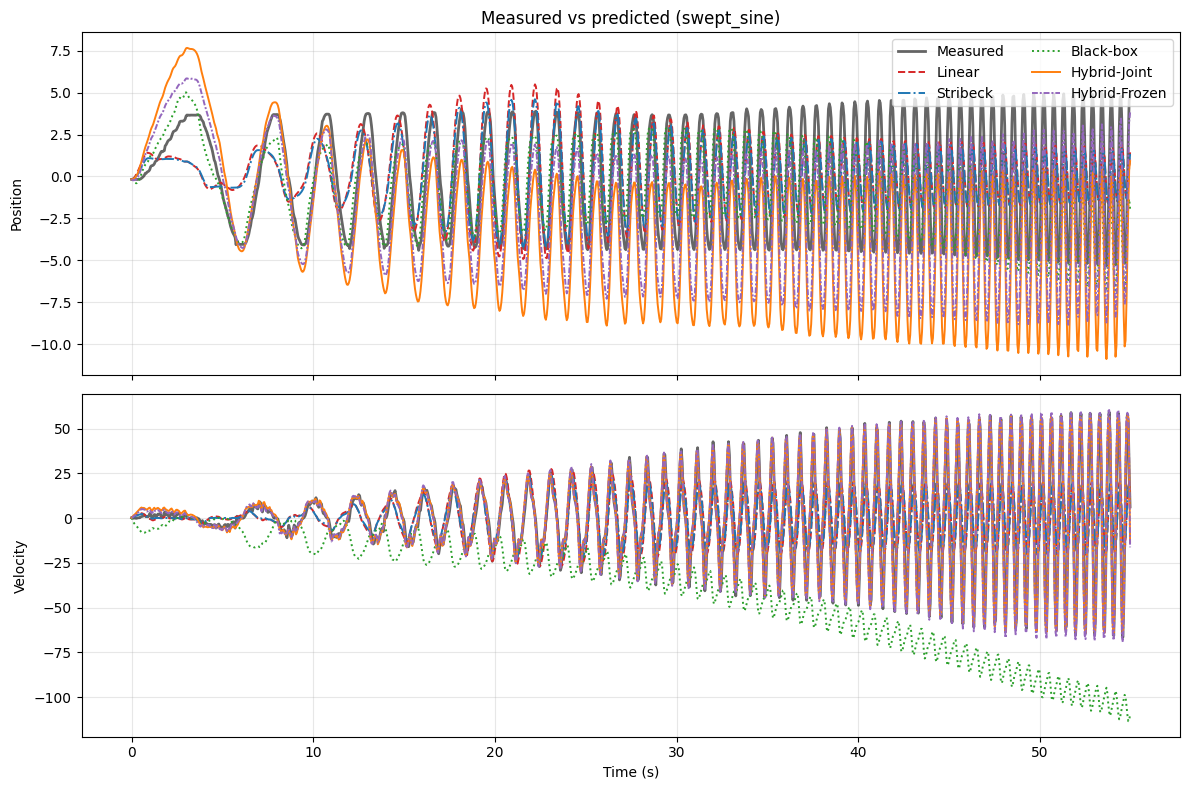

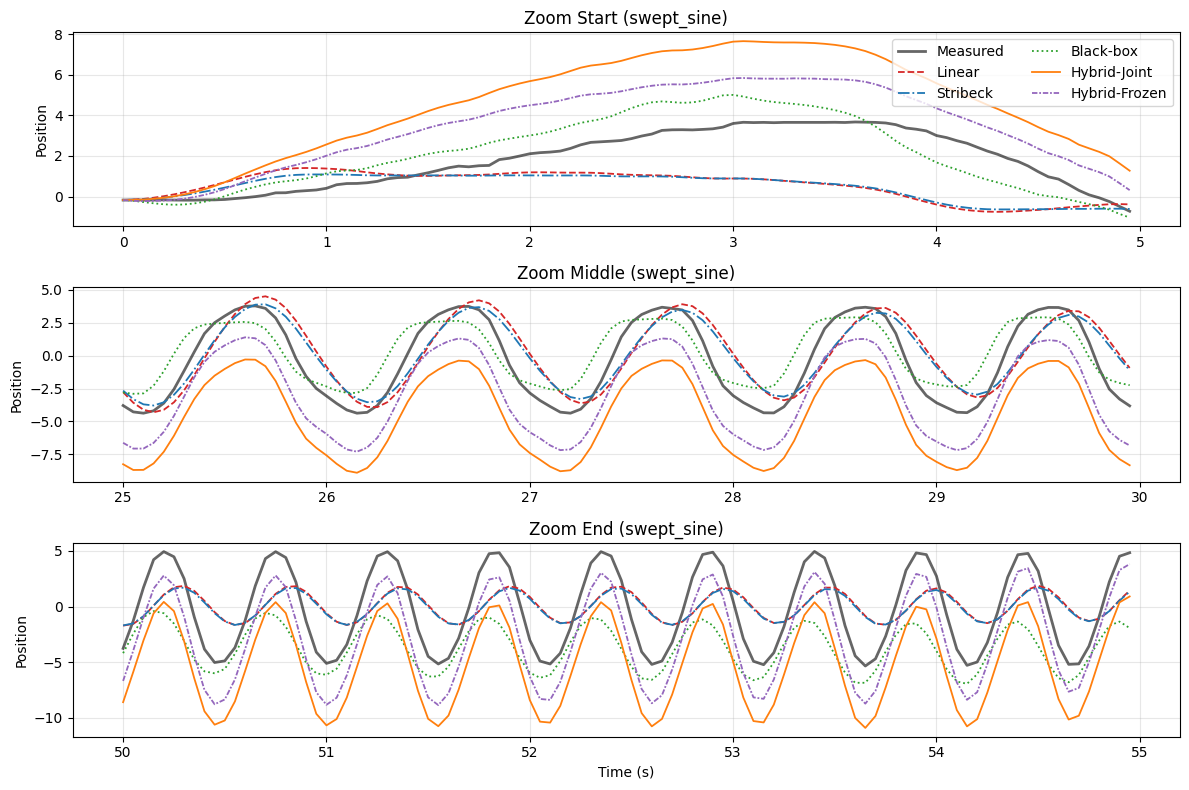

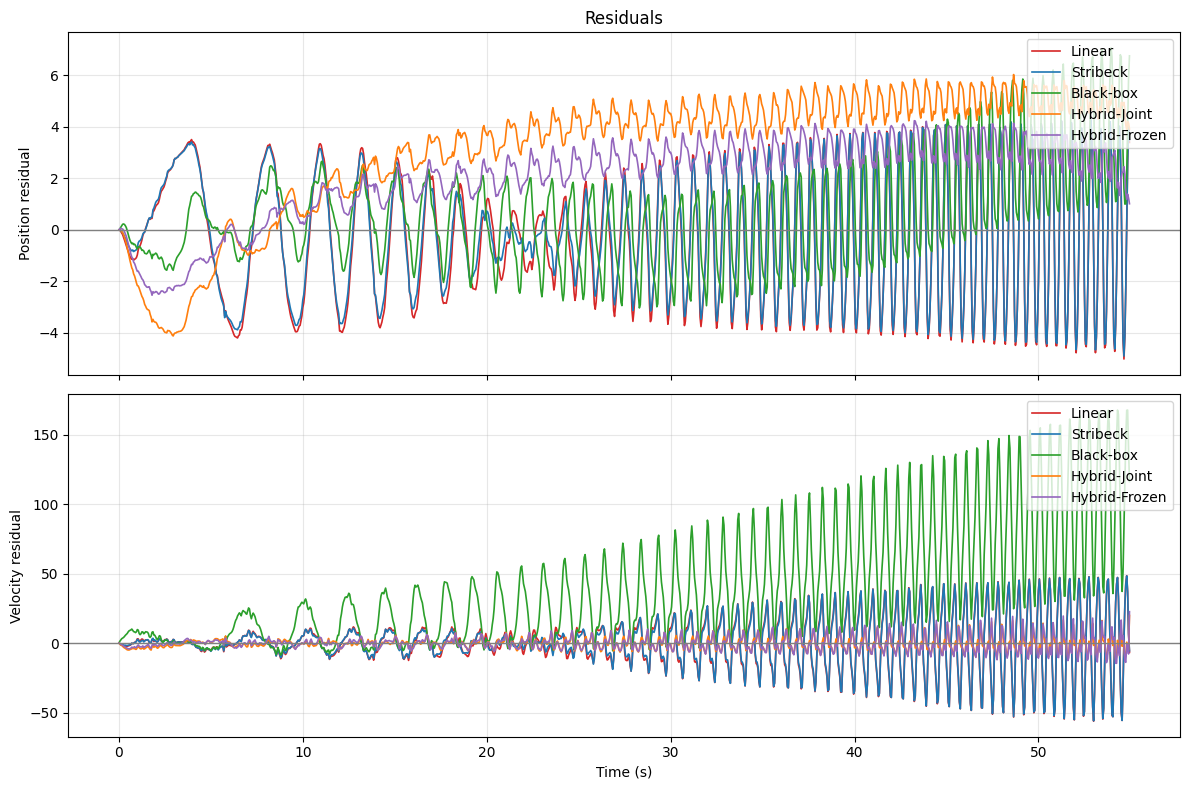

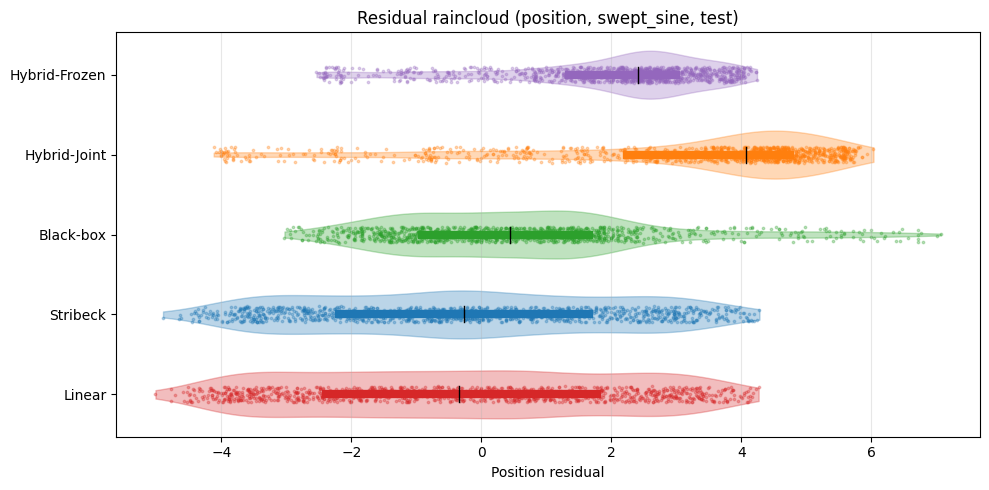

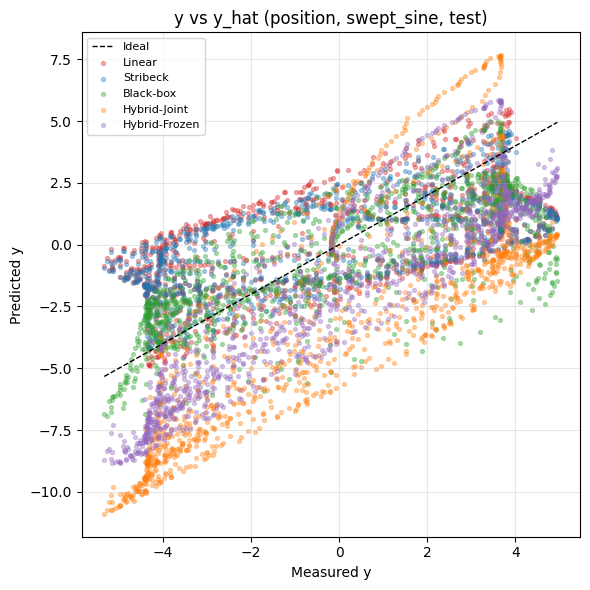

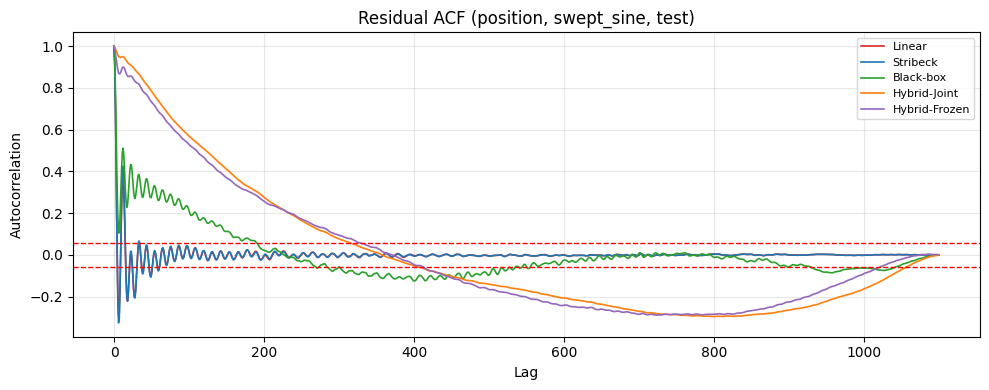

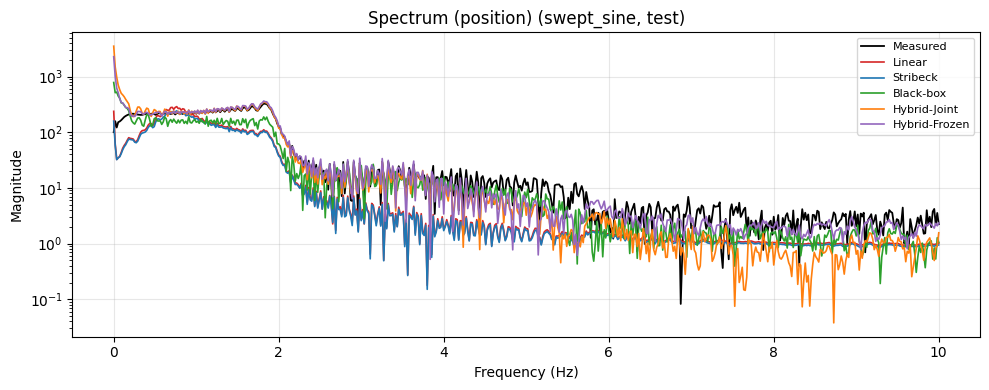

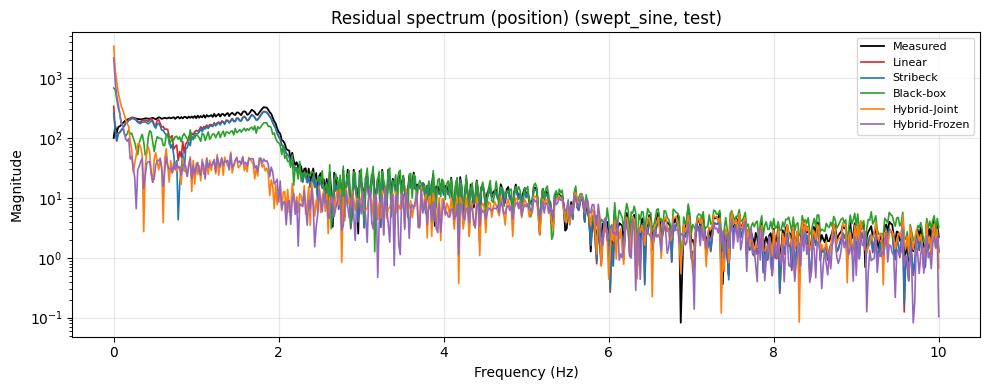

In [18]:
plot_dataset = "swept_sine"          # change as needed
plot_split = "test"                  # "train" or "test"
window_sec = 5.0

sel = best_eval_store[plot_dataset]
t = sel["t"]
Ts = sel["Ts"]
y_true = sel["y_true"]
preds = sel["preds"]

split_idx = None
if plot_split == "train":
    idx = sel["train_idx"]
    if idx.size == 0:
        raise ValueError(f"No train split for dataset {plot_dataset}")
    split_idx = int(sel["test_idx"][0]) if sel["test_idx"].size > 0 else None
elif plot_split == "test":
    idx = sel["test_idx"]
    if idx.size == 0:
        raise ValueError(f"No test split for dataset {plot_dataset}")
    split_idx = int(sel["test_idx"][0]) if sel["test_idx"].size > 0 else None
else:
    raise ValueError("plot_split must be 'train' or 'test'")

# Full-length overlays with train/test divider
plot_predictions(
    t=t,
    y_true=y_true,
    preds=preds,
    split_idx=split_idx,
    title_suffix=f"({plot_dataset})",
)

# Zoomed position windows
plot_zoom_position(
    t=t,
    y_true=y_true,
    preds=preds,
    Ts=Ts,
    window_sec=window_sec,
    title_suffix=f"({plot_dataset})",
)

# Residual time-series
_, residuals_all = plot_residuals(
    t=t,
    y_true=y_true,
    preds=preds,
    split_idx=split_idx,
)

# Split-specific vectors for scatter/raincloud/acf/spectrum
idx = sel[f"{plot_split}_idx"]
y_sel = y_true[idx]
preds_sel = {mk: yhat[idx] for mk, yhat in preds.items()}
residuals_sel_pos = {mk: (y_sel[:, 0] - preds_sel[mk][:, 0]) for mk in preds_sel.keys()}

plot_raincloud_models(
    residuals_pos=residuals_sel_pos,
    title=f"Residual raincloud (position, {plot_dataset}, {plot_split})",
)

plot_y_vs_yhat(
    y_true_pos=y_sel[:, 0],
    preds=preds_sel,
    title=f"y vs y_hat (position, {plot_dataset}, {plot_split})",
)

plot_acf(
    residuals_pos=residuals_sel_pos,
    title=f"Residual ACF (position, {plot_dataset}, {plot_split})",
)

plot_spectra(
    t=t[idx],
    Ts=Ts,
    y_true=y_sel,
    preds=preds_sel,
    title_suffix=f"({plot_dataset}, {plot_split})",
)


## 6) Raincloud grid across all datasets

Rows are model families (best checkpoint per family), columns are train/test, each y-axis entry is one dataset.


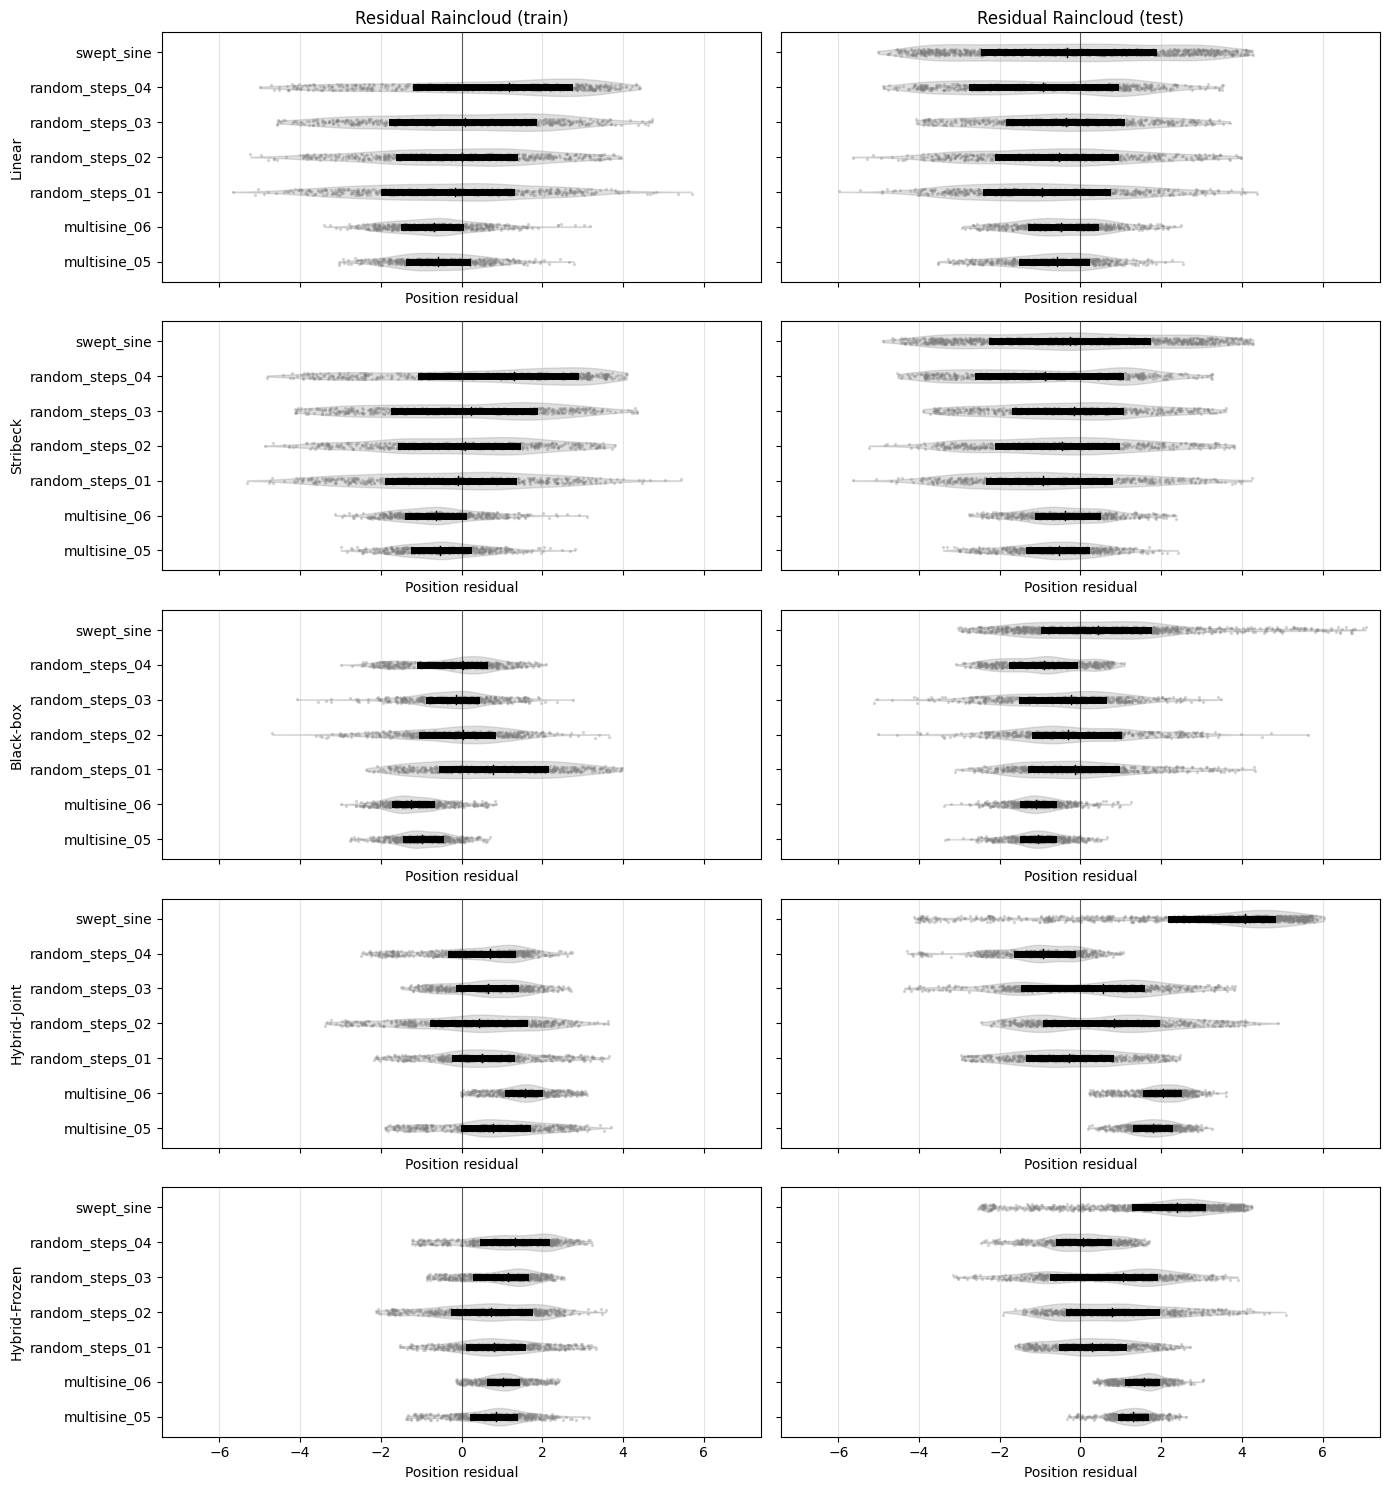

In [19]:
from scipy.stats import gaussian_kde

model_keys_order = list(best_models.keys())
dataset_order = list(best_eval_store.keys())
splits = ["train", "test"]

# Global symmetric x-limits around zero for fair visual comparison
all_res = []
for mk in model_keys_order:
    for ds_name in dataset_order:
        for sp in splits:
            rr = best_eval_store[ds_name]["residuals"][mk][sp]
            if rr is None:
                continue
            arr = np.asarray(rr["pos"])
            arr = arr[np.isfinite(arr)]
            if len(arr) > 0:
                all_res.append(arr)

if len(all_res) == 0:
    raise RuntimeError("No residuals available for raincloud grid")

all_concat = np.concatenate(all_res)
x_abs = np.max(np.abs(all_concat))
pad = 0.05 * (x_abs + 1e-12)
xlim_shared = (-(x_abs + pad), (x_abs + pad))

fig, axes = plt.subplots(
    len(model_keys_order),
    2,
    figsize=(14, max(3.0 * len(model_keys_order), 8)),
    sharex=True,
    sharey=True,
)
if len(model_keys_order) == 1:
    axes = np.array([axes])

for r, mk in enumerate(model_keys_order):
    for c, sp in enumerate(splits):
        ax = axes[r, c]
        for i, ds_name in enumerate(dataset_order):
            rr = best_eval_store[ds_name]["residuals"][mk][sp]
            if rr is None:
                continue

            res = np.asarray(rr["pos"])
            res = res[np.isfinite(res)]
            if len(res) < 5:
                continue

            xs = np.linspace(np.min(res), np.max(res), 200)
            kde = gaussian_kde(res)
            ys = kde(xs)
            ys = ys / max(ys.max(), 1e-12) * 0.25

            ax.fill_between(xs, i + ys, i - ys, color="gray", alpha=0.25)

            q1, q2, q3 = np.percentile(res, [25, 50, 75])
            ax.plot([q1, q3], [i, i], color="black", linewidth=5)
            ax.plot([q2, q2], [i - 0.12, i + 0.12], color="black", linewidth=1)

            jitter = (np.random.rand(len(res)) - 0.5) * 0.18
            ax.scatter(res, i + jitter, s=2, color="gray", alpha=0.25)

        if r == 0:
            ax.set_title(f"Residual Raincloud ({sp})")

        if c == 0:
            ax.set_ylabel(model_display_name(mk))
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Position residual")
        ax.axvline(0.0, color="k", linewidth=0.8, alpha=0.6)
        ax.grid(True, axis="x", alpha=0.35)
        ax.set_xlim(*xlim_shared)

        ax.set_yticks(range(len(dataset_order)))
        ax.set_yticklabels(dataset_order)

plt.tight_layout()
plt.show()


## 7) Optional: export best-model metrics


In [20]:
out_dir = RUN_DIR / "tables"
out_dir.mkdir(parents=True, exist_ok=True)

best_metrics_df.to_csv(out_dir / "best_models_metrics_long.csv", index=False)
r2_table.to_csv(out_dir / "best_models_r2_table.csv")
rmse_table.to_csv(out_dir / "best_models_rmse_table.csv")

print("Saved:")
print("-", out_dir / "best_models_metrics_long.csv")
print("-", out_dir / "best_models_r2_table.csv")
print("-", out_dir / "best_models_rmse_table.csv")


Saved:
- results/bab_runs/quick_local_with_swept/tables/best_models_metrics_long.csv
- results/bab_runs/quick_local_with_swept/tables/best_models_r2_table.csv
- results/bab_runs/quick_local_with_swept/tables/best_models_rmse_table.csv
